<a href="https://colab.research.google.com/github/annanasnas/digital_signal_processing/blob/main/%D0%A1%D0%A05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Самостоятельная работа №5

Выполнили: 

Сюракшина Анастасия БИБ191


Холодов Даниил БИБ191

### Двухмерное дискретное вейвлет-преобразование 2 уровня

In [1]:
from PIL import Image
import cv2.cv2 as cv
import numpy as np
from pywt import dwt2, wavedec2, waverec2, wavedec, waverec, threshold
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Original image



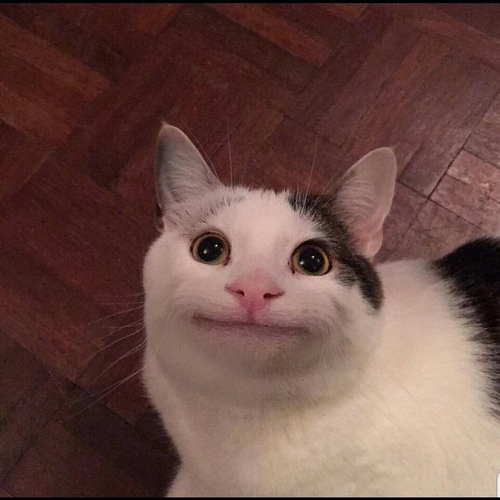

In [3]:
basewidth = 500
img = Image.open('/content/кот.jpeg')
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)

print("Original image\n")
img

<Figure size 432x288 with 0 Axes>

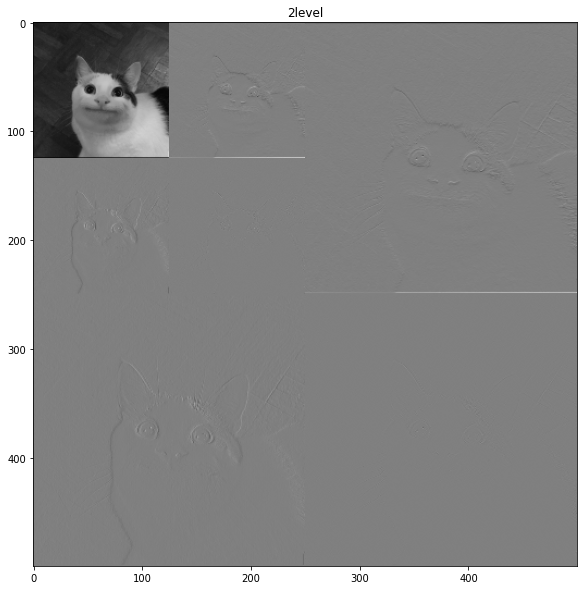

In [4]:
img = cv.imread('/content/кот.jpeg', 0)
if img.shape[1] > 500:
    (h, w) = img.shape[:2]
    width = 500
    height = int(h * (width / float(w)))
    img = cv.resize(img, (width, height), interpolation=cv.INTER_AREA)

#Single-level wavelet decomposition, returns are low-frequency components, horizontal high-frequency, vertical high-frequency, diagonal high-frequency, respectively equivalent to LL, HL, LH, HH in the figure above
cA, (cH, cV, cD) = dwt2(img, 'db3')
#Secondary wavelet decomposition
cA2, (cH2, cV2, cD2), (cH1, cV1, cD1) = wavedec2(img, 'haar', level=2)

#Combine each sub-image (low frequency cA value range [0,510], high frequency [-255,255])
AH = np.concatenate([cA, cH+255], axis=1)  #axis=1 means column splicing
VD = np.concatenate([cV+255, cD+255], axis=1)
res1 = np.concatenate([AH, VD], axis=0)

AH2 = np.concatenate([cA2, cH2+510], axis=1)
VD2 = np.concatenate([cV2+510, cD2+510], axis=1)
A2 = np.concatenate([AH2, VD2], axis=0)
AH1 = np.concatenate([A2, (cH1+255)*2], axis=1)
VD1 = np.concatenate([(cV1+255)*2, (cD1+255)*2], axis=1)
res2 = np.concatenate([AH1, VD1], axis=0)

#display
plt.figure('2D_DWT_2level')
plt.figure(figsize=(10,10))
plt.imshow(res2, cmap='gray', vmin=0, vmax=1020)
plt.title('2level')

plt.show()


Restored image



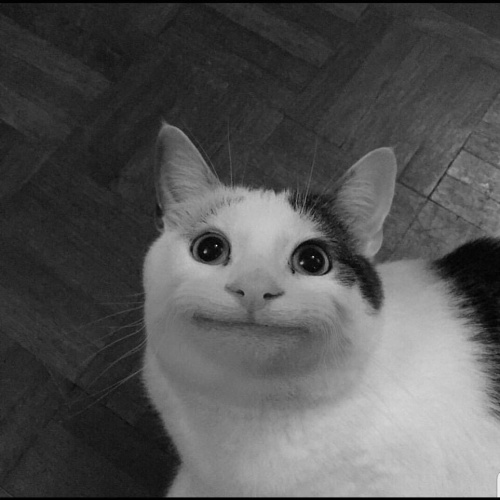

In [ ]:
coeffs = cA2, (cH2, cV2, cD2), (cH1, cV1, cD1)
array_restored = waverec2(coeffs, 'haar')

cv.imwrite('/content/картинка_восстановленная.jpeg', array_restored)

img_restored = Image.open('/content/картинка_восстановленная.jpeg')

print("Restored image\n")
img_restored

### Одномерное вейвлет-преобразование 3 уровня к AM-сигналу

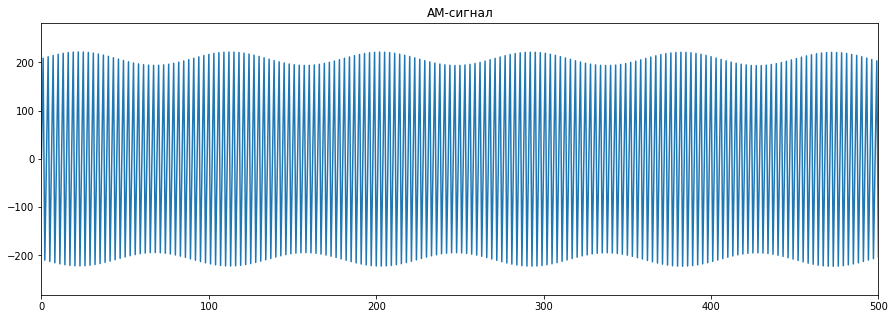

In [27]:
N = 16
A = 15 * N
B = N
f1 = 3 * 1000 * N
f2 = 100 * N
fs = 3 * f1

t = np.linspace(0, 1, fs)
x1 = A*np.sin(2*np.pi*f1*t)
x2 = B*np.sin(2*np.pi*f2*t)

AM = x1*(1+x2/A)

plt.figure(figsize=(15,5))
plt.plot(AM)
plt.title('АМ-сигнал')
plt.xlim(0, 500)
plt.show()

In [28]:
import pywt

def appcoef(coeffs, wavelet, level, **kwargs):
    max_level = len(coeffs) - 1
    if level == max_level:
        return coeffs[0]
    # this function also calculates the IDWT (kinda confusing API)
    approx = pywt.waverec2(coeffs[:-level], wavelet, **kwargs)
    # not sure why PyWavelets sometimes gives duplicate final rows/columns
    if np.all(approx[-1] == approx[-2]):
        approx = approx[:-1]
    if np.all(approx[:, -1] == approx[:, -2]):
        approx = approx[:, :-1]
    return approx

detcoef = lambda coeffs, level: coeffs[level]

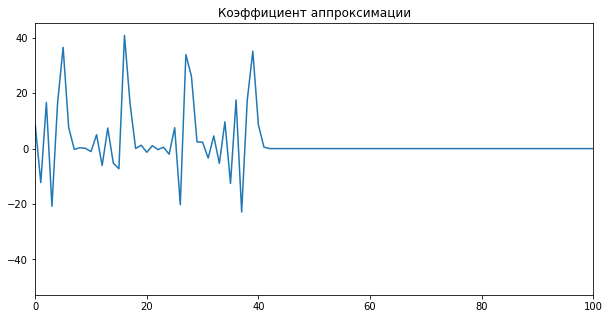

In [29]:
wavelet='db26'
level=3
coeffs = wavedec(AM, wavelet=wavelet, level=level)
cA = appcoef(coeffs, wavelet, level)
cD1 = detcoef(coeffs, 1)
cD2 = detcoef(coeffs, 2)
cD3 = detcoef(coeffs, 3)

plt.figure(figsize=(10,5))
plt.plot(cA)
plt.title("Коэффициент аппроксимации")
plt.xlim(0, 100)
plt.show()

Коэффициент детализации


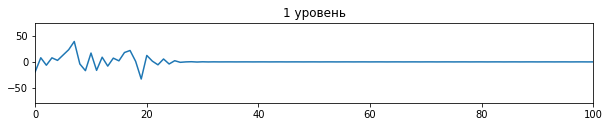

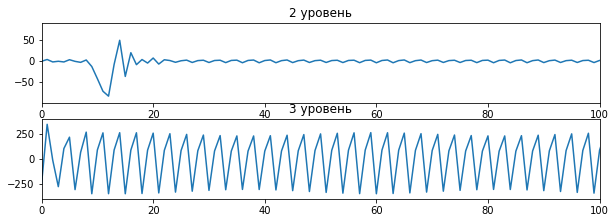

In [34]:
print('Коэффициент детализации')
plt.figure(figsize=(10,5))
plt.subplot(3, 1, 1)
plt.plot(cD1)
plt.xlim(0, 100)
plt.title('1 уровень')
plt.figure(figsize=(10,5))
plt.subplot(3, 1, 2)
plt.plot(cD2)
plt.xlim(0, 100)
plt.title('2 уровень')
plt.subplot(3, 1, 3)
plt.plot(cD3)
plt.xlim(0, 100)
plt.title('3 уровень')
plt.show()

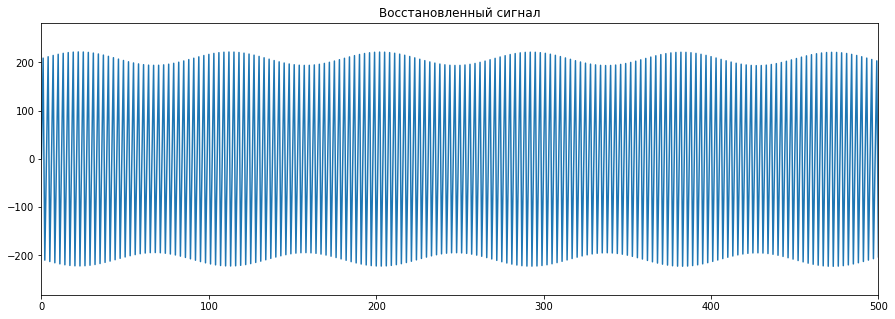

In [ ]:
AM_restored = waverec(coeffs, wavelet=wavelet)

plt.figure(figsize=(15,5))
plt.plot(AM_restored)
plt.title('Восстановленный сигнал')
plt.xlim(0, 500)
plt.show()

### Устранить при помощи вейвлет-преобразования шум для зашумленного АМ-сигнала

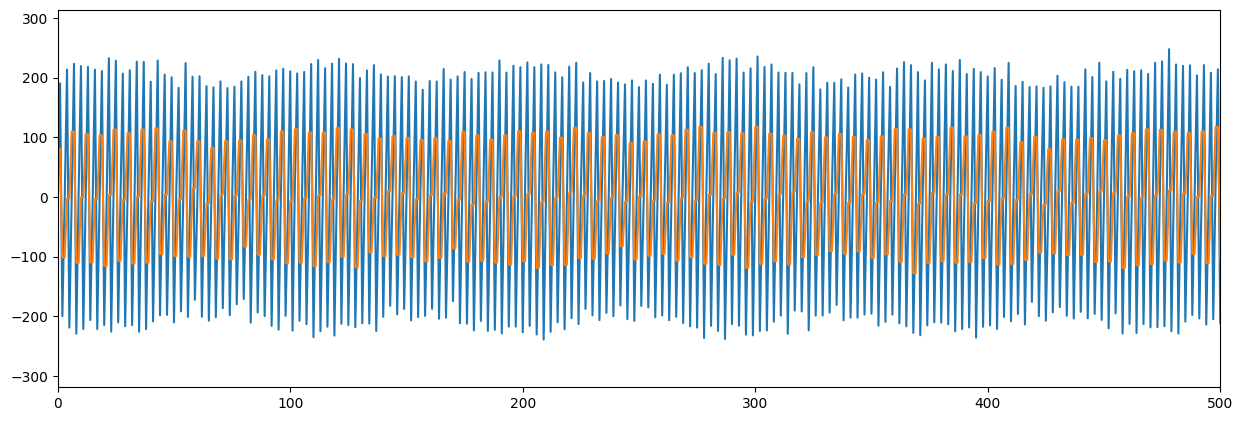

In [ ]:
from skimage.restoration import denoise_wavelet

sigma = 10
AM_noise =  AM + sigma*np.random.randn(len(t))

AM_denoise = denoise_wavelet(AM_noise, wavelet='db1', mode='soft', wavelet_levels=1, method='BayesShrink', rescale_sigma='True')

plt.figure(figsize=(15, 5), dpi=100)
plt.plot(AM_noise)
plt.plot(AM_denoise)
plt.xlim(0, 500)
plt.show()

### Разложение при помощи операции свёртки

In [5]:
import numpy as np
from scipy.ndimage.filters import convolve

def conv2(x,y,mode='same'):
    """
    Emulate the function conv2 from Mathworks.

    Usage:

    z = conv2(x,y,mode='same')

    TODO: 
     - Support other modes than 'same' (see conv2.m)
    """

    if not(mode == 'same'):
        raise Exception("Mode not supported")

    # Add singleton dimensions
    if (len(x.shape) < len(y.shape)):
        dim = x.shape
        for i in range(len(x.shape),len(y.shape)):
            dim = (1,) + dim
        x = x.reshape(dim)
    elif (len(y.shape) < len(x.shape)):
        dim = y.shape
        for i in range(len(y.shape),len(x.shape)):
            dim = (1,) + dim
        y = y.reshape(dim)

    origin = ()

    # Apparently, the origin must be set in a special way to reproduce
    # the results of scipy.signal.convolve and Matlab
    for i in range(len(x.shape)):
        if ( (x.shape[i] - y.shape[i]) % 2 == 0 and
             x.shape[i] > 1 and
             y.shape[i] > 1):
            origin = origin + (-1,)
        else:
            origin = origin + (0,)

    z = convolve(x,y, mode='constant', origin=origin)

    return z

In [6]:
!pip install pyyawt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 450 kB 4.3 MB/s 
  Created wheel for pyyawt: filename=pyyawt-0.1.1-cp37-cp37m-linux_x86_64.whl size=694128 sha256=e11c532ebd0a574de981440ed02120cf57adba19bfcbb9a8f319492510fc8c1e
  Stored in directory: /root/.cache/pip/wheels/ac/b0/2a/d97f2b93dc7b7ba620c4dda94e09131d0464bcc6c6151daf22
Successfully built pyyawt


Text(0.5, 1.0, 'Коэффициенты детализации')

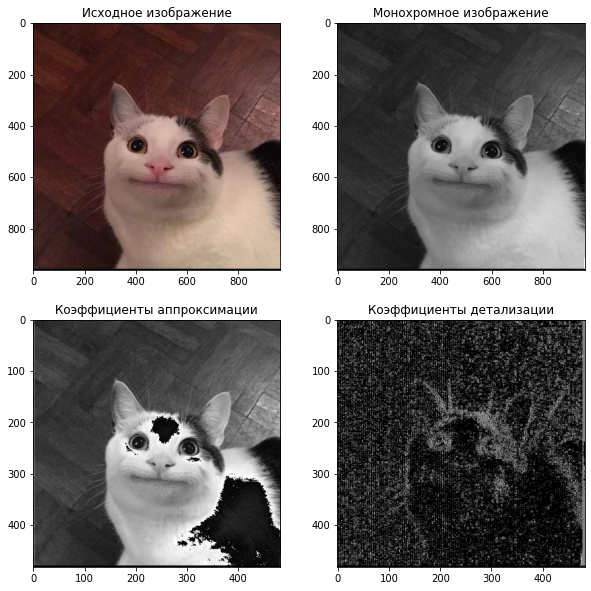

In [25]:
import cv2
import pyyawt
from scipy import signal
from skimage.measure import block_reduce

img = Image.open('/content/кот.jpeg')
img_gray = cv.imread('/content/кот.jpeg', 0)

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Исходное изображение')
plt.subplot(2, 2, 2)
plt.imshow(img_gray, cmap='gray')
plt.title('Монохромное изображение')
LoD, HiD = pyyawt.wfilters('db9', 'd') # Возвращает пару фильтров (нижнего и верхнего)
cA = block_reduce(conv2(img_gray, LoD), block_size=(2,2)) # Прорежение последовательности значений
cD = block_reduce(conv2(img_gray, HiD), block_size=(2,2)) # Путем удаление каждого второго отсчета
plt.subplot(2, 2, 3)
plt.imshow(cA, cmap='gray')
plt.title('Коэффициенты аппроксимации')
plt.subplot(2, 2, 4)
plt.imshow(cD, cmap='gray')
plt.title('Коэффициенты детализации')